# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

W&B Link: https://wandb.ai/lorenzozanolin-52/linear_regression/table?workspace=user-lorenzozanolin-52

## Preliminaries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#!pip install wandb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from imblearn.over_sampling import SMOTE
from torch import nn
from sklearn.model_selection import train_test_split
import wandb
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'): # '/kaggle/input'
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("a")
wandb.login(key=secret_value_0)

#hyperparameters and initialization of wandb project
num_iterations = 512
batch_size = 16
lr = 1e-3
wandb.init(project="linear_regression",config={"lr": lr, "epochs": num_iterations}) 
is_smt = True #decides whether to apply SMOTE
wandb.log({'SMOTE': is_smt})

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lorenzozanolin-52. Use `wandb login --relogin` to force relogin


## Data Processing

In [3]:
train_data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')    #'/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Let's see if the dataset is balanced w.r.t. the quality labels.

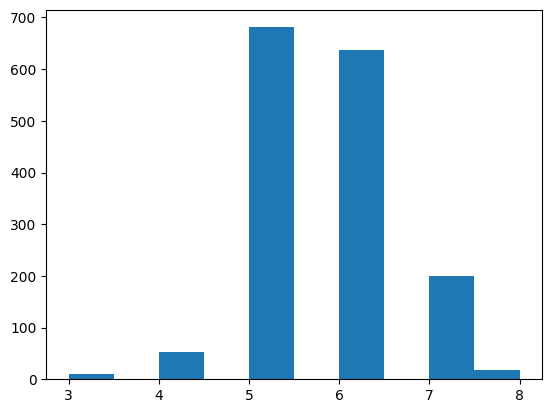

In [4]:
plt.hist(train_data.values[:,-1])   #plotting the last column of the dataset
plt.show()

As we can see, there are _unbalanced_ categories. 

First we will split the training set in two parts: *training* and *test* set. \
30% will be used as test set

In [5]:
X_train,X_test,y_train,y_test = train_test_split(train_data.iloc[:,:-1],train_data.iloc[:,-1],test_size=0.30) #splitting into training set and test set

Now we will use SMOTE to add new examples with labels 3,4 and 8 and re-balance the dataset.

Data before augmentation: quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64
Data after augmentation: quality
5    483
6    483
7    483
4    483
8    483
3    483
Name: count, dtype: int64


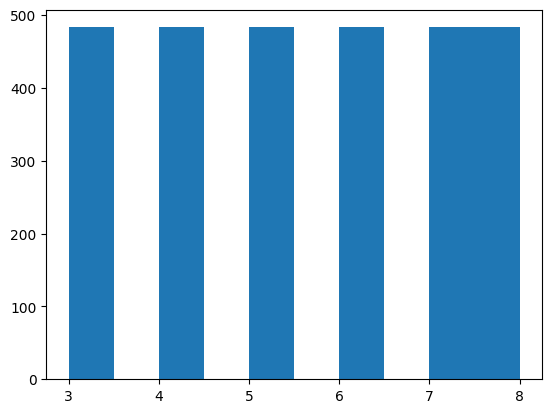

In [6]:
if is_smt:
    smt = SMOTE()
    X_train,y_train = smt.fit_resample(X_train,y_train)
    print("Data before augmentation:\f",train_data['quality'].value_counts())
    print("Data after augmentation:\f",y_train.value_counts())

    plt.hist(y_train)   #plotting the last column of the dataset
    plt.show()

As we can see, now data is slightly more balanced

Now we will *normalize* features in the following manner:
- mean and std will be computed on the *training* set
- these values will be used to compute the normalization on the *test* set

In [7]:
def normalize_features(X_train, X_test, y_train, y_test):
    global train_mean, train_std, pred_mean, pred_std

    train_mean = [0,0,0,0,0,0,0,0,0,0,0] 
    train_std =[0,0,0,0,0,0,0,0,0,0,0]
    
    for i in range(0, X_train.shape[1]-1):
        train_mean[i] = X_train[i].mean()
        train_std[i] = X_train[i].std()
    
        X_train = (X_train - train_mean[i])/train_std[i]
        X_test = (X_test - train_mean[i])/train_std[i]
    
    print(X_train)
    
    pred_mean = y_train.mean()
    pred_std = y_train.std()
    
    y_train = (y_train - pred_mean) / pred_std
    y_train = y_train.clone().detach()

    y_test = (y_test - pred_mean) / pred_std
    y_test = y_test.clone().detach()
    return X_train, X_test, y_train, y_test

def denormalize_features(X_train, X_test, y_train, y_test):
    global train_mean, train_std, pred_mean, pred_std
    
    for i in range(0, X_train.shape[1]-1):
        X_train = (X_train*train_std[i])+train_mean[i]
        X_test = (X_test*train_std[i])+train_mean[i]
    
    y_train = (y_train * pred_std)+pred_mean
    y_train = y_train.clone().detach()
    
    y_test = (y_test*pred_std) + pred_mean
    y_test = y_test.clone().detach()
    return X_train, X_test, y_train, y_test

#convert the sets from ndarray to tensor
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

X_train_N,X_test_N,y_train_n,y_test_n = normalize_features(X_train,X_test,y_train,y_test)   #normalizing the dataset

tensor([[ 0.2936, -0.6031, -0.5922,  ..., -0.3678, -0.5881,  0.2436],
        [ 0.0017, -0.6072, -0.5972,  ..., -0.3453, -0.5639,  0.3604],
        [ 0.0601, -0.5839, -0.6214,  ..., -0.3678, -0.5806,  0.1268],
        ...,
        [-0.1956, -0.5945, -0.6205,  ..., -0.3306, -0.5674,  0.5356],
        [-0.1471, -0.5637, -0.6278,  ..., -0.3361, -0.5645,  0.4422],
        [ 0.3149, -0.6055, -0.5780,  ..., -0.3816, -0.5630,  0.2515]])


## Training

Initialize the weights and bias of the linear regression

In [8]:
n_features = X_train.shape[1] #contains the number of features excluding the label
weights = torch.normal(0, 0.01, size=(n_features,1),requires_grad=True) # initialize a random tensor of weights, one weight for each feature
bias = torch.zeros(1, requires_grad=True)

Some functions definitions

In [9]:
from matplotlib import pyplot as plt

def linreg(X, w, b):        #linear regression
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):    #we will use stochastic GD
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
criterion = nn.MSELoss()    #the loss function will be mean squared error

def data_iter(batch_size, features, labels):    #to divide a single batch in multiple minibatches
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def print_result(y_true, y_pred):       #plot the graphs
    plt.clf()
    plt.plot(y_pred, 'ro', label='Predictions', alpha=0.5)
    plt.plot(y_true, 'go', label='True', alpha=0.5)
    plt.legend(loc='best')
    plt.colorbar
    plt.show()
    
def print_correctness(ground_truth,predicted_labels):       #prints the accuracy
    print('Mean Squared Error:\f',metrics.mean_squared_error(ground_truth,predicted_labels))
    print('Mean Absolute Error:\f',metrics.mean_absolute_error(ground_truth,predicted_labels))
    print('R-squared:\f',metrics.r2_score(ground_truth,predicted_labels))
    wandb.log({'R2': metrics.r2_score(ground_truth,predicted_labels)})
    wandb.log({'MAE': metrics.mean_absolute_error(ground_truth,predicted_labels)})
    wandb.log({'MSE': metrics.mean_squared_error(ground_truth,predicted_labels)})
    # now compute the number of correct guesses
    predicted_labels = predicted_labels.round()     #aproximation, since we need int values
    x=0
    for i in range(0,ground_truth.shape[0]-1):
        if(predicted_labels[i] == ground_truth[i]):
            x+=1
            
    print("Percentage of correct predictions: ", x/ground_truth.shape[0]*100,"%")

Training loop

In [10]:
# MINI BATCH, calculate for each round the derivative for each minibatch, and then sum up them together

print('Training loss:')
for i in range(num_iterations):
    for X, y in data_iter(batch_size, X_train_N, y_train_n):   
        loss = squared_loss(linreg(X,weights,bias),y)    #calculate the prediction, i.e. X(train features) * weights +b; then the loss w.r.t. labels
        loss.sum().backward() #derivate calc
        sgd([weights,bias],lr,batch_size)   #update weights
    with torch.no_grad():
        train_l = squared_loss(linreg(X, weights, bias), y) #loss of the final batch of the round
        print(f'epoch {i + 1}, loss {float(train_l.mean()):f}')
        wandb.log({'train loss': train_l.mean()})
        
    

Training loss:
epoch 1, loss 0.557612
epoch 2, loss 0.779842
epoch 3, loss 0.549752
epoch 4, loss 0.392594
epoch 5, loss 0.538161
epoch 6, loss 0.209057
epoch 7, loss 0.740952
epoch 8, loss 0.688947
epoch 9, loss 1.033472
epoch 10, loss 0.719841
epoch 11, loss 0.214569
epoch 12, loss 0.712922
epoch 13, loss 0.406974
epoch 14, loss 0.682727
epoch 15, loss 0.214458
epoch 16, loss 0.666863
epoch 17, loss 0.524949
epoch 18, loss 1.000493
epoch 19, loss 0.220139
epoch 20, loss 0.542254
epoch 21, loss 0.625013
epoch 22, loss 0.217962
epoch 23, loss 0.731170
epoch 24, loss 0.217866
epoch 25, loss 0.352845
epoch 26, loss 0.386149
epoch 27, loss 0.487852
epoch 28, loss 1.015487
epoch 29, loss 0.512314
epoch 30, loss 0.235048
epoch 31, loss 0.147188
epoch 32, loss 0.536311
epoch 33, loss 0.072513
epoch 34, loss 0.231714
epoch 35, loss 0.664921
epoch 36, loss 0.651695
epoch 37, loss 0.206684
epoch 38, loss 1.023272
epoch 39, loss 0.321821
epoch 40, loss 0.506121
epoch 41, loss 0.674073
epoch 42, 

## Testing

We need to calculate the loss also over the test set

In [11]:
# test on the test dataset
with torch.no_grad():
    test_l = 0
    for X, y in data_iter(batch_size, X_test_N, y_test_n):
        test_l += squared_loss(linreg(X, weights, bias), y).sum()
    test_l /= len(X_test)
    print(f'loss on the test dataset {float(test_l):f}')
    wandb.log({'test loss': test_l})

loss on the test dataset 0.121633


## Results

Finally, the obtained predictions are the following. 

We will evaluate the model using the following metrics:
- **Mean Squared Error**: computes the average of the squared differences between predicted and actual values.
- **Mean Absolute Error**: calculates the average absolute difference between the predicted and actual values.
- **R-squared**: indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.

Mean Squared Error: 0.70977104
Mean Absolute Error: 0.6661447
R-squared: -0.08777887266614348
Percentage of correct predictions:  43.958333333333336 %


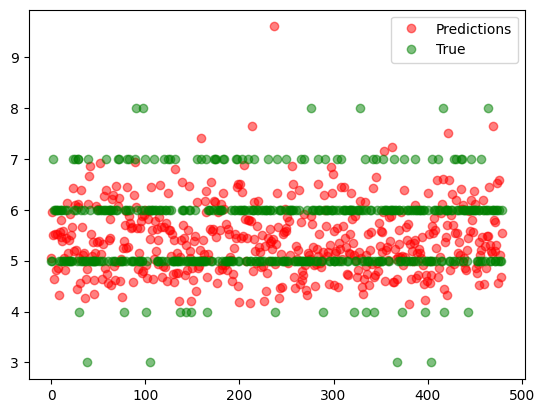

In [12]:
test_predictions_N = []
with torch.no_grad():
    for X in X_test_N:
        test_predictions_N.append(linreg(X,weights,bias))       #we calculate all the predictions on the test set

_,_,test_predictions,y_test = denormalize_features(X_train_N,X_test_N,torch.tensor(test_predictions_N),y_test_n)    #we denormalize the features

#test_predictions = test_predictions.round()     #aproximation, since we need int values

with torch.no_grad():
    print_correctness(y_test,test_predictions)  #prints accuracy
    print_result(y_test,test_predictions)
    

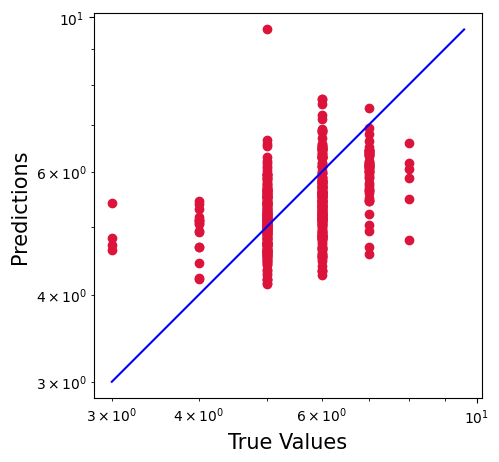

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test), max(test_predictions))
p2 = min(min(test_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()